In [1]:
import wandb
from src.models import PINN
from src.train_utils import get_pde, get_data, predict
from src.pyhessian import hessian
import torch
import torch.nn as nn
import bz2
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
entity_name = 'sketchy-opts'  # Replace with your entity name
project_name = 'convection_lbfgs_v2'
pde = 'convection'
pde_params = ['beta', '30']
opt = 'lbfgs'
loss = 'mse'
num_layers = 4
num_neurons = 200
num_t = 101
num_x = 101
initial_seed = 123
time = 1000
device = 'cuda:0'
root_path = '/home/pratikr/opt_for_pinns'

In [3]:
api = wandb.Api()

In [4]:
# function that generates densities and bins
def generate_density_bins(eigenvalues, weights, num_bins=10000, gaussian_variance=1e-5, zero_eps=1e-7, use_log_scale=True):

    # parameters
    margin_percentage = 1/100

    # project to real plane
    eigenvalues = np.real(eigenvalues)
    weights = np.real(weights)

    # get eigenvalue statistics
    num_runs = eigenvalues.shape[0]
    max_eig = np.mean(np.max(eigenvalues, axis=1), axis=0)
    min_eig = np.mean(np.min(eigenvalues, axis=1), axis=0)

    # compute bins
    neg_bins = []
    pos_bins = []
    if min_eig > 0:
        lower = min_eig * (1 - margin_percentage)
        upper = max_eig * (1 + margin_percentage)
        if use_log_scale:
            pos_bins = np.linspace(
                np.log10(lower), np.log10(upper), num=num_bins)
        else:
            pos_bins = np.linspace(lower, upper, num=num_bins)

    elif max_eig < 0:
        lower = min_eig * (1 + margin_percentage)
        upper = max_eig * (1 - margin_percentage)
        if use_log_scale:
            neg_bins = np.linspace(
                np.log10(-lower), np.log10(-upper), num=num_bins)
        else:
            neg_bins = np.linspace(lower, upper, num=num_bins)
    else:
        lower = min_eig * (1 + margin_percentage)
        upper = max_eig * (1 + margin_percentage)

        # here we have 1 additional points at 0
        num_neg_bins = max(2, int(-lower / (-lower + upper) * (num_bins - 1)))
        num_pos_bins = max(2, (num_bins - 1) - num_neg_bins)
        num_bins = num_neg_bins + num_pos_bins + 1

        if use_log_scale:
            neg_bins = np.linspace(
                np.log10(-lower), np.log10(zero_eps), num=num_neg_bins)
            pos_bins = np.linspace(
                np.log10(zero_eps), np.log10(upper), num=num_pos_bins)
        else:
            neg_bins = np.linspace(lower, -zero_eps, num=num_neg_bins)
            pos_bins = np.linspace(zero_eps, upper, num=num_pos_bins)

    # helper function to compute Gaussian density
    def gaussian(x, x0, sigma_squared):
        return np.exp(-(x0 - x)**2 / (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

    # estimate densities
    variance = gaussian_variance * max(1, (upper - lower))
    density = np.zeros((num_runs, num_bins))
    for i in range(num_runs):
        for j in range(len(neg_bins)):
            if use_log_scale:
                point = -1 * (10 ** neg_bins[j])
            else:
                point = neg_bins[j]
            approximate_density = gaussian(eigenvalues[i, :], point, variance)
            density[i, j] = np.sum(approximate_density * weights[i, :])

        density_idx_offset = len(neg_bins)
        if (min_eig < 0) and (max_eig > 0):
            approximate_density = gaussian(eigenvalues[i, :], 0, variance)
            density[i, density_idx_offset] = np.sum(
                approximate_density * weights[i, :])
            density_idx_offset += 1

        for j in range(len(pos_bins)):
            if use_log_scale:
                point = 10 ** pos_bins[j]
            else:
                point = pos_bins[j]
            approximate_density = gaussian(eigenvalues[i, :], point, variance)
            density[i, density_idx_offset +
                    j] = np.sum(approximate_density * weights[i, :])

    # assemble bins
    if (min_eig < 0) and (max_eig > 0):
        if use_log_scale:
            bins = np.concatenate(
                [-1 * np.power(10, neg_bins), [0], np.power(10, pos_bins)])
        else:
            bins = np.concatenate([neg_bins, [0], pos_bins])
    elif len(neg_bins) > 0:
        if use_log_scale:
            bins = -1 * np.power(10, neg_bins)
        else:
            bins = neg_bins
    else:
        if use_log_scale:
            bins = np.power(10, pos_bins)
        else:
            bins = pos_bins

    # normalize
    density = np.mean(density, axis=0)  # average runs
    density += zero_eps  # add epsilon
    bin_avg_density = 0.5 * (density[:-1] + density[1:])
    bin_length = np.diff(bins, axis=0)
    total_density = np.sum(bin_length * bin_avg_density)
    density = density / total_density

    return density, bins

In [5]:
# Fetch the run with the given parameters
runs = api.runs(f'{entity_name}/{project_name}')

def get_run_id(runs, pde, pde_params, opt, loss, num_layers, num_neurons, num_x, num_t, initial_seed):
    for run in runs:
        if run.state == 'finished':
            if run.config['pde'] == pde \
                and run.config['pde_params'] == pde_params \
                and run.config['opt'] == opt \
                and run.config['loss'] == loss \
                and run.config['num_layers'] == num_layers \
                and run.config['num_neurons'] == num_neurons \
                and run.config['num_x'] == num_x \
                and run.config['num_t'] == num_t \
                and run.config['initial_seed'] == initial_seed:
                return run.id
    raise ValueError('Run not found')

In [6]:
run_id = get_run_id(runs, pde, pde_params, opt, loss, num_layers, num_neurons, num_x, num_t, initial_seed)
print(run_id)

9rxv9mv6


In [7]:
def get_model_at_time(root_path, project_name, run_id, num_neurons, num_layers, time, device):
    model = PINN(in_dim=2, hidden_dim=num_neurons, out_dim=1, num_layer=num_layers).to(device)

    with bz2.open(f'{root_path}/{project_name}_temp/{run_id}/weights_history.bz2', 'rb') as f:
        compressed_data = f.read()

    weights_history = pickle.loads(compressed_data)

    # Convert each element of the list of lists to a torch tensor
    for i in range(len(weights_history)):
        for j in range(len(weights_history[i])):
            weights_history[i][j] = torch.from_numpy(weights_history[i][j]).to(device)

    idx = 0
    for module in model.linear:
        if isinstance(module, nn.Linear):
            module.weight = nn.Parameter(weights_history[time][idx])
            module.bias = nn.Parameter(weights_history[time][idx + 1])
            idx += 2

    return model

In [8]:
model = get_model_at_time(root_path, project_name, run_id, num_neurons, num_layers, time, device)

In [9]:
x_range, t_range, loss_func, pde_coefs = get_pde(pde, pde_params, loss)
x, t = get_data(x_range, t_range, num_x, num_t, random=False, device=device)

In [10]:
hessian_comp = hessian(model=model, pred_func=predict,
                       loss_func=loss_func, data=(x, t), cuda=True, device=device)

In [11]:
density_eigen, density_weight = hessian_comp.density(n_v=10)

In [12]:
density, bins = generate_density_bins(
    density_eigen, density_weight, use_log_scale=True)

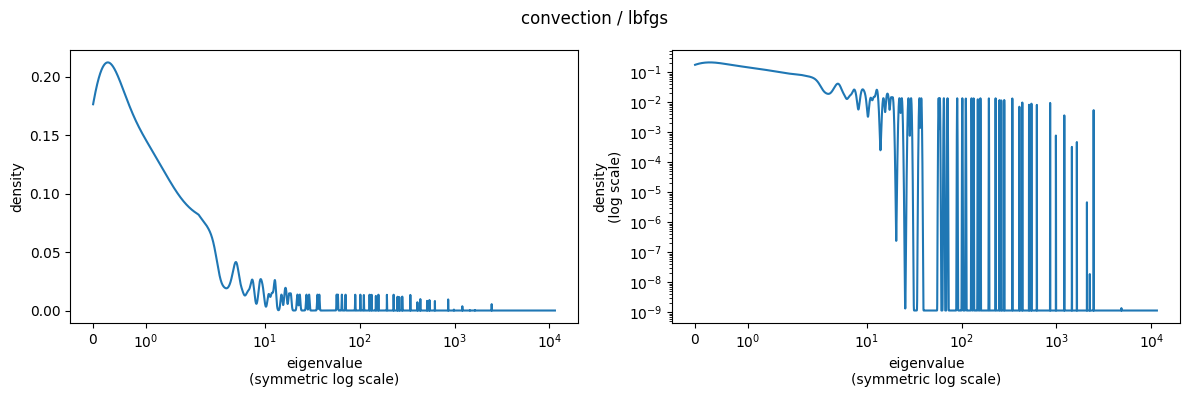

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(f'{pde} / {opt}')

ax1.plot(bins, density)
ax1.set_xscale('symlog')
ax1.set_ylabel('density')
ax1.set_xlabel('eigenvalue\n(symmetric log scale)')

ax2.semilogy(bins, density)
ax2.set_xscale('symlog')
ax2.set_ylabel('density\n(log scale)')
ax2.set_xlabel('eigenvalue\n(symmetric log scale)')

plt.tight_layout()
plt.show()

In [14]:
def plot_spectrum(runs, pde, pde_params, opt, loss, num_layers, num_neurons, num_x, num_t, initial_seed,
                  root_path, project_name, time, device, n_v=10):
    run_id = get_run_id(runs, pde, pde_params, opt, loss, num_layers, num_neurons, num_x, num_t, initial_seed)

    model = get_model_at_time(root_path, project_name, run_id, num_neurons, num_layers, time, device)
    
    x_range, t_range, loss_func, _ = get_pde(pde, pde_params, loss)
    
    x, t = get_data(x_range, t_range, num_x, num_t, random=False, device=device)
    
    hessian_comp = hessian(model=model, pred_func=predict,
                        loss_func=loss_func, data=(x, t), cuda=True, device=device)

    density_eigen, density_weight = hessian_comp.density(n_v=n_v)

    density, bins = generate_density_bins(
        density_eigen, density_weight, use_log_scale=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{pde} / {opt}')

    ax1.plot(bins, density)
    ax1.set_xscale('symlog')
    ax1.set_ylabel('density')
    ax1.set_xlabel('eigenvalue\n(symmetric log scale)')

    ax2.semilogy(bins, density)
    ax2.set_xscale('symlog')
    ax2.set_ylabel('density\n(log scale)')
    ax2.set_xlabel('eigenvalue\n(symmetric log scale)')

    plt.tight_layout()
    plt.show()

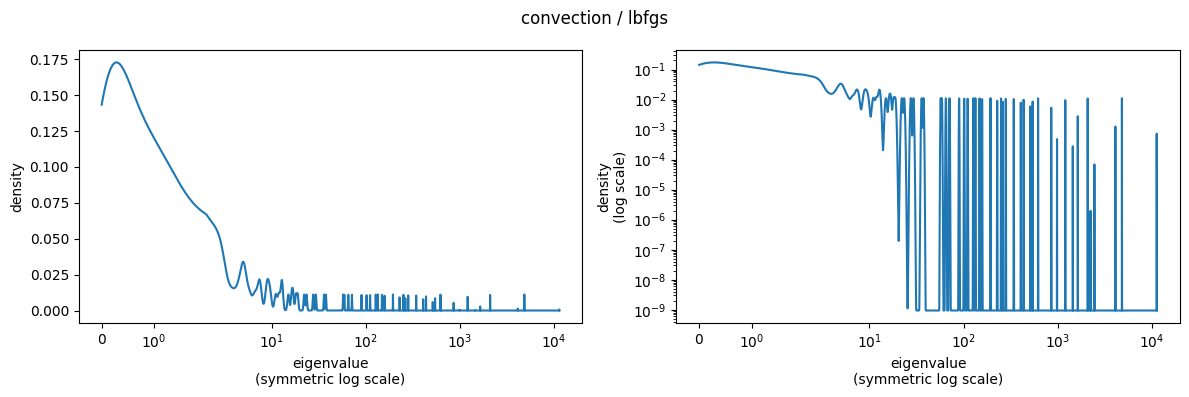

In [15]:
plot_spectrum(runs, pde, pde_params, opt, loss, num_layers, num_neurons, num_x, num_t, initial_seed,
            root_path, project_name, time, device, n_v=10)